In [1]:
import numpy as np
import os
import configparser
import shutil
import cv2

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plotn
from keras.optimizers import SGD
from keras import models

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from collections import OrderedDict


import sys
sys.path.insert(0, './lib_keras/')
from help_functions import *

from lib_keras.model_lib import *
#function to obtain data for training/testing (validation)
from temp_extract_patches import temp_get_data_training
import random
from tensorflow import set_random_seed

print(K.tensorflow_backend._get_available_gpus())
SEED = 5

np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
set_random_seed(SEED)
random.seed(SEED)

Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
save_folder = config.get('experiment name','result_save_path')
name_experiment = config.get('experiment name', 'name')

#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

mapping = OrderedDict()
mapping[(0,0,0)] = 0
mapping[(255,0,0)] = 1
mapping[(0,0,255)] = 2

if os.path.isdir('./'+save_folder+'/'+name_experiment+'/') == False:
    os.mkdir('./'+save_folder+'/'+name_experiment+'/')
else:
    print('already exist the folder in this path : {}'.format('./'+save_folder+'/'+name_experiment+'/'))


In [3]:
patches_imgs_train, patches_masks_train, class_freq_tabel = temp_get_data_training(
    train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    label_mapping = mapping,
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment
)
print('Done!')

already exist the folder in this path : result/20_0621_fine_segmentor_180_Data_focal_gamma_07
number of subimages :  240000
[DEBUG] shape of train_imgs_original :  (180, 3, 500, 760)
[DEBUG] shape of train_imgs_label :  (180, 3, 500, 760)


[get_data_training] preprocessed image shape :  (180, 1, 500, 760)

[get_data_training] preprocessed mask shape :  (180, 3, 500, 760)
mask maximum val :  255.0
[get_data_training] preprocessed2 image shape :  (180, 1, 500, 760)


[padding] pad h size : 12	 pad w size : 8


[padding] imgs shape : (180, 500, 760, 1)	 labels shape : (180, 500, 760, 3)


[padding] pad imgs shape : (180, 512, 768, 1)	 pad labels shape : (180, 512, 768, 3)


extract patches:   0%|          | 0/180 [00:00<?, ?it/s]



[final pad] imgs shape : (180, 512, 768, 1)	 labels shape : (180, 512, 768, 3)


[final transpose] imgs shape : (180, 1, 512, 768)	 labels shape : (180, 3, 512, 768)


[get_data_training] train images/masks shape : (180, 1, 512, 768)
[get_data_training] train images range (min-max) [0.0 , 255.0] 
[get_data_training] train masks are within 0-1



[extract random] num of class :  3
[extract random] full image shape : (180, 1, 512, 768)
[extract random] full masks shape : (180, 3, 512, 768)
[extract random] patches shape : (240000, 1, 64, 64)
[extract random] patches masks shape : (240000, 3, 64, 64)
[extract random] patches per full image : 1333
aug patch shape : (64, 64, 1) aug mask shape : (64, 64, 3)


extract patches: 100%|██████████| 180/180 [11:54<00:00,  3.97s/it]


[After patch] mask shape :  (240000, 3, 64, 64)


[get_data_training] train PATCHES images/masks shape : (240000, 1, 64, 64)
[get_data_training] train PATCHES images range (min-max): 0.0 - 1.0
[get_data_training] patches_imgs_train : (240000, 1, 64, 64)
Done!


In [4]:
class_freq_tabel

,class_0,class_1,class_2,frequency_0,frequency_1,frequency_2
0,5364470,70627,70627,0.974344,0.0128279,0.0128279
1,5274082,165015,165015,0.941109,0.0294453,0.0294453
2,5260732,177547,177547,0.936769,0.0316155,0.0316155
3,5271121,174549,174549,0.937885,0.0310573,0.0310573
4,5270079,168462,168462,0.93991,0.0300449,0.0300449
5,5248362,192492,192492,0.93166,0.0341701,0.0341701
6,5273102,166100,166100,0.940735,0.0296327,0.0296327
7,5238733,199414,199414,0.929255,0.0353724,0.0353724
8,5277064,169227,169227,0.939729,0.0301356,0.0301356
9,5281500,163447,163447,0.941713,0.0291433,0.0291433


In [5]:
import pandas as pd

average_class_freq = pd.DataFrame(columns=['avg_class_00', 'avg_class_01', 'avg_class_02', 'avg_freq_00','avg_freq_01','avg_freq_02'])

average_class_freq.loc[0,'avg_class_00'] = class_freq_tabel['class_0'].mean()
average_class_freq.loc[0,'avg_class_01'] = class_freq_tabel['class_1'].mean()
average_class_freq.loc[0,'avg_class_02'] = class_freq_tabel['class_2'].mean()


average_class_freq.loc[0,'avg_freq_00'] = class_freq_tabel['frequency_0'].mean()
average_class_freq.loc[0,'avg_freq_01'] = class_freq_tabel['frequency_1'].mean()
average_class_freq.loc[0,'avg_freq_02'] = class_freq_tabel['frequency_2'].mean()

class_freq_tabel.to_csv('./'+save_folder+'/'+name_experiment+'/'+'all_class_imbalance.csv', encoding='utf-8')
average_class_freq.to_csv('./'+save_folder+'/'+name_experiment+'/'+'avg_class_imbalance.csv', encoding='utf-8')


In [6]:

patches_masks_train_class00 = patches_masks_train[:,0,:,:] 
patches_masks_train_class00 = np.expand_dims(patches_masks_train_class00,1)
patches_masks_train_class01 = patches_masks_train[:,1,:,:] 
patches_masks_train_class01 = np.expand_dims(patches_masks_train_class01,1)
patches_masks_train_class02 = patches_masks_train[:,2,:,:] 
patches_masks_train_class02 = np.expand_dims(patches_masks_train_class02,1)



print(np.shape(patches_masks_train_class00))

(240000, 1, 64, 64)


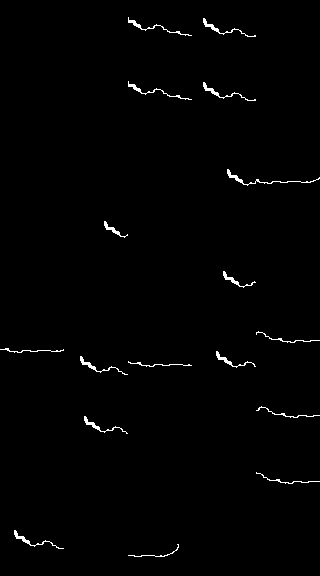

In [7]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train_class00[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass0")#.show()
visualize(group_images(patches_masks_train_class01[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass1")#.show()
visualize(group_images(patches_masks_train_class02[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass2")#.show()


In [8]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]
print('shape : ',patches_imgs_train.shape)
print('n_ch : {} patch_h : {} patch_w : {}'.format(n_ch, patch_height, patch_width))
#model = naive_attn_unet(n_ch, patch_height, patch_width)  #the U-net model
#model = unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))

#model = bigger_unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = bigger_naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))
model = class3_attn_unet(n_ch, patch_height, patch_width,len(mapping))
#model = attn_reg_test(n_ch, patch_height, patch_width,len(mapping))

print ("Check: final output of the network:")
print (model.output_shape)

#plot(model, to_file= './'+save_folder+'/'+name_experiment+'/' +name_experiment+ '_model.png')   #check how the model looks like
#plot(model, to_file= name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+save_folder+'/'+name_experiment+'/' +name_experiment+'_architecture.json', 'w').write(json_string)


shape :  (240000, 1, 64, 64)
n_ch : 1 patch_h : 64 patch_w : 64
input shape :  (None, 1, 64, 64)

gating shape : (None, 128, 4, 4), conv4 shape : (None, 64, 8, 8)
shape x,g  (None, 64, 8, 8) (None, 128, 4, 4)
inter shape :   128
stride x : 1 stride y : 1
theta_x shape :  (None, 128, 4, 4)
upsample_g shape :  (None, 128, 4, 4)

attn1 shape : (None, 64, 8, 8) center shape : (None, 128, 4, 4) 

attn1 shape : (None, 64, 8, 8) up1 shape : (None, 128, 8, 8)
shape x,g  (None, 64, 16, 16) (None, 128, 8, 8)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 8, 8)
upsample_g shape :  (None, 64, 8, 8)
shape x,g  (None, 32, 32, 32) (None, 128, 16, 16)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 16, 16)
upsample_g shape :  (None, 64, 16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (Inp

41736

In [9]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.callbacks import Callback
import math

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # 1e-9 + (1e-6 ) * (1 + cos ())
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1)

print('[training session] mask unet func patch mask shape :q ',patches_masks_train.shape)
patches_masks_train = np.reshape(patches_masks_train, (patches_masks_train.shape[0], len(mapping), patch_height* patch_width))
patches_masks_train = np.transpose(patches_masks_train,(0,2,1))
#patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] After mask unet func patch mask shape : ',patches_masks_train.shape)






[training session] mask unet func patch mask shape :q  (240000, 3, 64, 64)
[training session] After mask unet func patch mask shape :  (240000, 4096, 3)


In [10]:
print(np.shape(patches_imgs_train))

(240000, 1, 64, 64)


In [11]:
try:
    history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer,CosineAnnealingScheduler(T_max=200, eta_max=5e-6, eta_min=1e-7),early_stopping])
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
except KeyboardInterrupt:
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
    print('Keyboard Interrupt')

Train on 192000 samples, validate on 48000 samples
Epoch 1/200
192000/192000 [==============================] - 819s 4ms/step - loss: 12.3379 - generalized_dice_coeff: 0.6958 - val_loss: 7.0606 - val_generalized_dice_coeff: 0.7213

Epoch 00001: val_loss improved from inf to 7.06064, saving model to ./result/20_0621_fine_segmentor_180_Data_focal_gamma_07/best_weights.h5
Epoch 2/200
192000/192000 [==============================] - 820s 4ms/step - loss: 6.1894 - generalized_dice_coeff: 0.7426 - val_loss: 5.5164 - val_generalized_dice_coeff: 0.7418

Epoch 00002: val_loss improved from 7.06064 to 5.51643, saving model to ./result/20_0621_fine_segmentor_180_Data_focal_gamma_07/best_weights.h5
Epoch 3/200
192000/192000 [==============================] - 829s 4ms/step - loss: 5.3544 - generalized_dice_coeff: 0.7589 - val_loss: 5.0845 - val_generalized_dice_coeff: 0.7700

Epoch 00003: val_loss improved from 5.51643 to 5.08448, saving model to ./result/20_0621_fine_segmentor_180_Data_focal_gamma

dict_keys(['val_loss', 'generalized_dice_coeff', 'val_generalized_dice_coeff', 'lr', 'loss'])


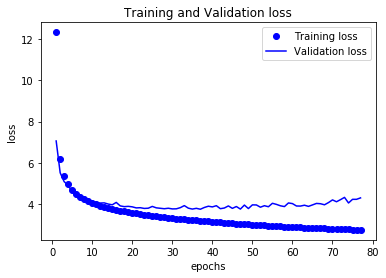

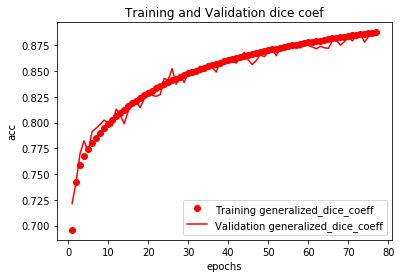

already exist the folder in this path : ./result/20_0621_fine_segmentor_180_Data_focal_gamma_07/train_history
already exist the folder in this path : ./result/20_0621_fine_segmentor_180_Data_focal_gamma_07/train_history
already exist the folder in this path : ./result/20_0621_fine_segmentor_180_Data_focal_gamma_07/train_history


In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['generalized_dice_coeff']
val_acc = history.history['val_generalized_dice_coeff']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training generalized_dice_coeff")
plt.plot(epochs, val_acc, 'r', label = "Validation generalized_dice_coeff")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()

import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')